### Technical Things To Do
- Setup nuts/bolts and try imitation learning on one level (done)
- Optimize imitation learning training on one level
- Setup nuts/bolts and try imitation learning on all levels, test generalization (not strictly necessary for the goal of this work)
- Specify a generic evaluation protocol that can be used for all agents
    - Fixed frame score over a number of evaluation attempts at the same level, mean.
- Try learning from scratch with an RL, record the mean episodic reward throughout training.
- Use the same agent but pre-trained with human demonstrations, record the mean episodic reward throughout training.

In [1]:
import base64
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import retro
import io
import time
import pandas as pd

from gym import wrappers
from IPython.display import clear_output

%matplotlib inline

In [47]:
levels = [
    'MarbleZone.Act1','MarbleZone.Act2','MarbleZone.Act3',
    'GreenHillZone.Act1','GreenHillZone.Act2','GreenHillZone.Act3',
    'LabyrinthZone.Act1','LabyrinthZone.Act2','LabyrinthZone.Act3', 
    'SpringYardZone.Act1','SpringYardZone.Act2','SpringYardZone.Act3', 
    'StarLightZone.Act1','StarLightZone.Act2','StarLightZone.Act3',
    'ScrapBrainZone.Act1','ScrapBrainZone.Act2' 
]

config = {}
config['train_levels'] = [level for level in levels if 'Act1' in level]
config['dev_levels'] = [level for level in levels if 'Act3' in level]
config['data_path'] = os.path.abspath("./data/human")

In [48]:
config['train_levels']

['MarbleZone.Act1',
 'GreenHillZone.Act1',
 'LabyrinthZone.Act1',
 'SpringYardZone.Act1',
 'StarLightZone.Act1',
 'ScrapBrainZone.Act1']

In [49]:
config['dev_levels']

['MarbleZone.Act3',
 'GreenHillZone.Act3',
 'LabyrinthZone.Act3',
 'SpringYardZone.Act3',
 'StarLightZone.Act3']

In [3]:
def extract_human_data(movie_path):
    """ Given a path to a replay file, load it and 
        extract the series of state-action pairs.
    """
    movie = retro.Movie(movie_path)
    movie.step()

    env = retro.make(game=movie.get_game(), state=retro.State.NONE, 
                     use_restricted_actions=retro.Actions.ALL)
    env.initial_state = movie.get_state()
    state = env.reset()

    states, actions, next_states, rewards, dones = [], [], [], [], []
    while movie.step():
        keys = []
        for i in range(len(env.buttons)):
            keys.append(movie.get_key(i, 0))
            
        next_state, reward, done, info = env.step(keys)
        actions.append(np.int8(keys))
        states.append(state)
        next_states.append(next_state)
        rewards.append(reward)
        dones.append(done)
        
        state = next_state
        
    return states, actions, next_states, rewards, dones

In [8]:
states, actions, next_states, rewards, dones = extract_human_data("data/human/SonicTheHedgehog-Genesis-LabyrinthZone.Act1-0000.bk2")

In [9]:
unique_actions, counts = np.unique(actions, axis=0, return_counts=True)

ordering = np.argsort(counts)[::-1]
unique_actions = unique_actions[ordering]
counts = counts[ordering]
print(unique_actions, counts)

[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0 0 0]
 [0 1 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 0 0 0]
 [0 1 0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 1 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 0 0 0]] [6070 4300 2459 1910  783  532  126   94   35   20   20   10    8    2
    1    1]


In [10]:
print(f"Identified {len(counts)} unique actions of {2**12} possible.")

Identified 16 unique actions of 4096 possible.


In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
str_actions = ["".join(str(a)) for a in actions]
encoded_actions = LabelEncoder().fit_transform(str_actions)

In [13]:
len(encoded_actions)

16371

In [14]:
np.unique(encoded_actions)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [13]:
transition_matrix = np.zeros((16,16), dtype=np.int16)

for i in range(len(actions) - 1):
    transition_matrix[encoded_actions[i], encoded_actions[i+1]] += 1 

In [14]:
import seaborn as sns

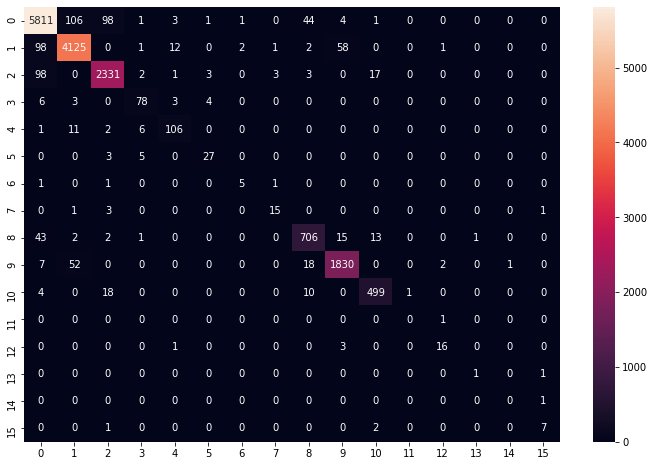

In [15]:
plt.figure(figsize=(12,8))
sns.heatmap(transition_matrix, annot=True, fmt='d')

In [16]:
def watch_human_game(states):
    """ Pass in the states and watch a human
        game replay.
    """

    plt.figure(figsize=(12,12))
    for state in states:
        plt.imshow(state)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        time.sleep(0.00002)
        clear_output(wait=True)

In [17]:
# This takes some time.  The framerate is 
# significantly slower than realtime.
# watch_human_game(states)

In [18]:
import tensorflow as tf

In [19]:
inputs = tf.keras.layers.Input(states[0].shape)
last_layer = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, activation='relu')(inputs)
last_layer = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=3, activation='relu')(last_layer)
last_layer = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, activation='relu')(last_layer)
last_layer = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=3, activation='relu')(last_layer)
last_layer = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, activation='relu')(last_layer)
last_layer = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=3, activation='relu')(last_layer)
flat_layer = tf.keras.layers.Flatten()(last_layer)
last_layer = tf.keras.layers.Dense(256, activation='relu')(flat_layer)
outputs = tf.keras.layers.Dense(actions[0].shape[0], activation='sigmoid')(last_layer)
model = tf.keras.Model(inputs, outputs)

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3), 
    loss='binary_crossentropy'
)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 320, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 318, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 74, 106, 16)       2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 104, 16)       2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 34, 16)        2320      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 32, 16)        2320      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 10, 16)         2320  

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
x_train, x_test, y_train, y_test = train_test_split(np.array(states), np.array(actions))

In [23]:
model.train_on_batch(x_train[:32], y_train[:32])

1.6960676

In [24]:
for epoch in range(10):
    epoch_loss = 0
    for batch in range(100):
        indices = np.random.choice(np.arange(x_train.shape[0]), 32)
        loss = model.train_on_batch(x_train[indices], y_train[indices])
        epoch_loss += loss / 100
        
    print("Epoch loss: ", epoch_loss)
    print("Dev. loss: ", model.evaluate(x_test, y_test))

Epoch loss:  0.1446262334287167
4093/4093 [==============================] - 2s 575us/sample - loss: 0.1222
Dev. loss:  0.12216122137533258
Epoch loss:  0.11104777757078409
4093/4093 [==============================] - 2s 520us/sample - loss: 0.1166
Dev. loss:  0.11662853009145067
Epoch loss:  0.09603700570762154
4093/4093 [==============================] - 2s 519us/sample - loss: 0.1050
Dev. loss:  0.10504605307275848
Epoch loss:  0.09055924732238056
4093/4093 [==============================] - 2s 539us/sample - loss: 0.1013
Dev. loss:  0.10125396364829722
Epoch loss:  0.08032281097024682
4093/4093 [==============================] - 2s 515us/sample - loss: 0.1017
Dev. loss:  0.10169052515218056
Epoch loss:  0.07303433906286953
4093/4093 [==============================] - 2s 519us/sample - loss: 0.0909
Dev. loss:  0.09086318179735658
Epoch loss:  0.06606416456401348
4093/4093 [==============================] - 2s 516us/sample - loss: 0.0852
Dev. loss:  0.08520847850044812
Epoch loss:  0

In [25]:
def watch_imitation_game(env, model, max_steps=200, rnd_steps=50):
    """ Docstring.
    """

    plt.figure(figsize=(12,12))
    
    state = env.reset()
    for step in range(rnd_steps):
        state, _, _, _ = env.step(env.action_space.sample())
    
    for step in range(max_steps):
        
        # Act according to our policy most of the time.  It 
        # seems to get stuck so I am trying to add some random
        # elements to get Sonic unstuck.
        if step % 10 == 0:
            new_state, reward, done, info = env.step(env.action_space.sample())
            state = new_state
        else:
            action = model.predict(state.reshape(1, *state.shape))
            action = np.round(action[0])
            action = np.array(action, dtype=np.int8)
            new_state, reward, done, info = env.step(action)
        
        screen = env.render(mode='rgb_array')
        
        # Draw to the screen and wait a moment
        # so the user can see it. 
        plt.imshow(screen)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        time.sleep(0.0002)
        clear_output(wait=True)
    
        if done:
            break

In [26]:
env.close()
env = retro.make(game='SonicTheHedgehog-Genesis', state='LabyrinthZone.Act1')
# watch_imitation_game(env, model, max_steps=10000, rnd_steps=100)

In [42]:
class BaseAgent:
    """ Docstring. """
    
    def __init__(self, config):
        self.config = config
        
    def act(self, state):
        raise NotImplementedException

In [27]:
def record_imitation_game(env, model, rnd_steps=50, max_frames=10000):
    """ Docstring.
    """
    
    
    state = env.reset()
    frames = []
    frames.append(env.render(mode='rgb_array'))
    for step in range(rnd_steps):
        state, _, _, _ = env.step(env.action_space.sample())
        frames.append(env.render(mode='rgb_array'))
        
    done = False
    while not done:
        
        # Act according to our policy most of the time.  It 
        # seems to get stuck so I am trying to add some random
        # elements to get Sonic unstuck.
        if step % 5 == 0:
            new_state, reward, done, info = env.step(env.action_space.sample())
            state = new_state
        
        else:
            action = model.predict(state.reshape(1, *state.shape))
            action = np.round(action[0])
            action = np.array(action, dtype=np.int8)
            new_state, reward, done, info = env.step(action)
            state = new_state
            
        frames.append(env.render(mode='rgb_array'))
        if len(frames) % 500 == 0:
            print("Collected {} frames".format(len(frames)))
        
        if len(frames) >= max_frames:
            return frames
        
    return frames

In [28]:
frames = record_imitation_game(env, model, rnd_steps=50, max_frames=3000)

Collected 500 frames
Collected 1000 frames
Collected 1500 frames
Collected 2000 frames
Collected 2500 frames
Collected 3000 frames
Collected 3500 frames
Collected 4000 frames
Collected 4500 frames
Collected 5000 frames


<Figure size 864x864 with 0 Axes>

In [29]:
try:
    import imageio
except:
    !pip install imageio
    !pip install imageio-ffmpeg
    import imageio

In [30]:
imageio.mimwrite("imitation_agent.mp4", frames, fps=30)

In [31]:
print(os.listdir('data/human'))

['SonicTheHedgehog-Genesis-MarbleZone.Act2-0000.bk2', 'SonicTheHedgehog-Genesis-GreenHillZone.Act2-0000.bk2', 'SonicTheHedgehog-Genesis-LabyrinthZone.Act3-0000.bk2', 'SonicTheHedgehog-Genesis-MarbleZone.Act1-0000.bk2', 'SonicTheHedgehog-Genesis-SpringYardZone.Act3-0000.bk2', 'SonicTheHedgehog-Genesis-StarLightZone.Act1-0000.bk2', 'SonicTheHedgehog-Genesis-GreenHillZone.Act1-0000.bk2', 'SonicTheHedgehog-Genesis-SpringYardZone.Act2-0000.bk2', 'SonicTheHedgehog-Genesis-LabyrinthZone.Act1-0000.bk2', 'SonicTheHedgehog-Genesis-StarLightZone.Act2-0000.bk2', 'SonicTheHedgehog-Genesis-SpringYardZone.Act1-0000.bk2', 'SonicTheHedgehog-Genesis-ScrapBrainZone.Act2-0000.bk2', 'SonicTheHedgehog-Genesis-GreenHillZone.Act3-0000.bk2', 'SonicTheHedgehog-Genesis-ScrapBrainZone.Act1-0000.bk2', 'SonicTheHedgehog-Genesis-LabyrinthZone.Act2-0000.bk2', 'SonicTheHedgehog-Genesis-MarbleZone.Act3-0000.bk2', 'SonicTheHedgehog-Genesis-StarLightZone.Act3-0000.bk2']


In [53]:
def format_demo_name(level):
    return 'SonicTheHedgehog-Genesis-{}-0000.bk2'.format(level)

In [54]:
env.close()
_states, _actions, _next_states, _rewards, _dones = [], [], [], [], []

for demo in config['train_levels']:
    print(f"Extracting {demo}")
    s, a, ns, r, d = extract_human_data(os.path.join(config['data_path'], format_demo_name(demo)))
        
    _states.extend(s)
    _actions.extend(a)
    _next_states.extend(ns)
    _rewards.extend(r)
    _dones.extend(d)

Extracting MarbleZone.Act1
Extracting GreenHillZone.Act1
Extracting LabyrinthZone.Act1
Extracting SpringYardZone.Act1
Extracting StarLightZone.Act1
Extracting ScrapBrainZone.Act1


In [55]:
inputs = tf.keras.layers.Input(states[0].shape)
last_layer = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, activation='relu')(inputs)
last_layer = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=3, activation='relu')(last_layer)
last_layer = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, activation='relu')(last_layer)
last_layer = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=3, activation='relu')(last_layer)
last_layer = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, activation='relu')(last_layer)
last_layer = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=3, activation='relu')(last_layer)
flat_layer = tf.keras.layers.Flatten()(last_layer)
last_layer = tf.keras.layers.Dense(256, activation='relu')(flat_layer)
outputs = tf.keras.layers.Dense(actions[0].shape[0], activation='sigmoid')(last_layer)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3), 
    loss='binary_crossentropy'
)
print(model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 320, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 222, 318, 16)      448       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 74, 106, 16)       2320      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 104, 16)       2320      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 34, 16)        2320      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 22, 32, 16)        2320      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 10, 16)         2320

In [56]:
class ModelTrainer:
    
    def __init__(self, max_epochs=10, batch_size=32, 
                 steps_per_epoch=100, patience=4):
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch
        self.train_loss = []
        self.test_loss = []
        self.best_loss = np.inf
        self.best_weights = None
        self.patience = patience
        
    def train(self, model, x_train, y_train, x_test, y_test):  
        
        down_rounds = 0
        for epoch in range(self.max_epochs):
            epoch_loss = 0
            for batch in range(self.steps_per_epoch):
                indices = np.random.choice(np.arange(x_train.shape[0]), self.batch_size)
                loss = model.train_on_batch(x_train[indices], y_train[indices])
                epoch_loss += loss / self.steps_per_epoch
        
            epoch_test_loss = model.evaluate(x_test, y_test)
            self.train_loss.append(epoch_loss)
            self.test_loss.append(epoch_test_loss)
            print("Epoch loss: ", epoch_loss)
            print("Dev. loss: ", epoch_test_loss)
            
            if epoch_test_loss > self.best_loss:
                down_rounds += 1
            else:
                self.best_loss = epoch_test_loss
                self.best_weights = model.get_weights()
                down_rounds = 0
                
            if down_rounds >= self.patience:
                return

In [ ]:
trainer = ModelTrainer(20, 32, 40)
trainer.train(model, x_train, y_train, x_test, y_test)

4093/4093 [==============================] - 2s 546us/sample - loss: 0.1455
Epoch loss:  0.31878157816827307
Dev. loss:  0.1455061479933303
4093/4093 [==============================] - 2s 520us/sample - loss: 0.1355
Epoch loss:  0.14371035397052764
Dev. loss:  0.13547449005959292
4093/4093 [==============================] - 2s 523us/sample - loss: 0.1307
Epoch loss:  0.12961007598787547
Dev. loss:  0.13074200166602779
4093/4093 [==============================] - 2s 520us/sample - loss: 0.1248
Epoch loss:  0.12097926586866377
Dev. loss:  0.12484145395124625
4093/4093 [==============================] - 2s 516us/sample - loss: 0.1170
Epoch loss:  0.11825458761304614
Dev. loss:  0.11701451029356377
4093/4093 [==============================] - 2s 519us/sample - loss: 0.1192
Epoch loss:  0.10753378942608835
Dev. loss:  0.11920929772402994
4093/4093 [==============================] - 2s 523us/sample - loss: 0.1090
Epoch loss:  0.10889252126216886
Dev. loss:  0.10896811583151073
4093/4093 [===

In [ ]:
plt.plot(trainer.train_loss, label='Train')
plt.plot(trainer.test_loss, label='Dev')
plt.grid(alpha=0.2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [37]:
env.close()
env = retro.make(game='SonicTheHedgehog-Genesis', state='LabyrinthZone.Act1')
frames = record_imitation_game(env, model, rnd_steps=50, max_frames=5000)
imageio.mimwrite("imitation_agent_generalization.mp4", frames, fps=30)

Collected 500 frames
Collected 1000 frames
Collected 1500 frames
Collected 2000 frames
Collected 2500 frames
Collected 3000 frames
Collected 3500 frames
Collected 4000 frames
Collected 4500 frames
Collected 5000 frames


<Figure size 864x864 with 0 Axes>